  # Test of MLP model
  
 
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Softmax
from tensorflow.keras.utils import plot_model

  ### Definition of names for plots and files

In [2]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4_withYSO_fromSimbad.csv'
features_file = '../ZTF_data/features20191119_withWISE.csv'

class_output = '../ZTF_classifications/MLP_noe_hierarchical_classification_unlabelled_set_withWISE_20191119.csv'

#where the RF models are saved
model_name = 'stat_xgboost_onevsrest/xgboost_onevsrest_'+date

#confusion matrixes
conf_matrix_name = 'stat_xgboost_onevsrest/confusion_matrix_xgboost_onevsrest_'+date


In [3]:
mapper = {'SNIa':0, 
 'SNIbc':1, 
 'SNII':2,
 'SLSN':3,
 'QSO-I':4,
 'AGN-I':5, 
 'Blazar':6, 
 'CV/Nova':7,
 'LPV':8,
 'YSO':9,
 'EBSD/D':10, 
 'EBC': 11, 
 'DSCT': 12, 
 'RRL': 13, 
 'Ceph': 14, 
 'RS-CVn': 15,
 'Periodic-Other':16
}
def encode(y):
    return y.apply(lambda x: mapper[x])

def encode_array(y):
    #return np.apply_along_axis(lambda x: mapper[x],y,0)
    return [mapper[x] for x in y ]


def decode(y):
    de_mapper = dict(zip(mapper.values(),mapper.keys()))
    return y.apply(lambda x: de_mapper[x])

def decode_array(y):
    de_mapper = dict(zip(mapper.values(),mapper.keys()))
    #return np.apply_along_axis(lambda x: de_mapper[x],y,0)
    return [de_mapper[x] for x in y ]




### reading the training set files 

In [4]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


164213


In [5]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'



#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF18aawaqeo,CV/Nova
ZTF18acaxfpa,CV/Nova
ZTF18abxehba,CV/Nova
ZTF18aaxjjwu,CV/Nova
ZTF18abnowur,CV/Nova


In [6]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

111421
111421
111421
111421


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaact,11.0,0.139977,0.328509,1.0,0.363636,0.0,0.472415,-0.031614,2.395997,0.004443,...,322.582369,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-0.067,1.769,-999.000000,-999.000000
ZTF17aaaaahl,59.0,0.458348,0.956996,6.0,0.338983,0.0,0.032239,0.532763,3.447957,0.016959,...,229.373142,849.637793,0.983051,0.928571,0.850714,0.500000,0.166,0.659,9.668436,9.009436
ZTF17aaaaajz,0.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,143.078357,-999.000000,0.022727,0.701429,0.979167,-0.020,0.405,9.511996,9.106996
ZTF17aaaaaly,10.0,0.110826,0.427705,2.0,0.300000,0.0,0.201831,0.001717,0.055476,0.003597,...,4.144941,88.598544,1.000000,0.954545,0.684286,0.794833,-0.051,0.468,10.309124,9.841124
ZTF17aaaaasi,113.0,2.734854,1.000000,18.0,0.433628,0.0,0.002209,0.871545,0.226679,0.107707,...,245.809905,-660.435165,0.539823,0.534351,0.686667,0.902500,0.460,1.695,11.667063,9.972063


  ### Defining functions to plot the confusion matrix and the feature importance

In [7]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [8]:
Y_original = labels['class_original']

Y_original_encoded = encode(Y_original)
print(Y_original_encoded)
X_original = df.values


#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
                                                Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

'''scaler = MinMaxScaler()
scaler.fit(X_train_original)'''

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_original)

X_train = scaler.transform(X_train_original)-0.5
X_test = scaler.transform(X_test_original)-0.5

X_train, X_valid, y_train_original, y_valid_original = model_selection.train_test_split(X_train,
                                                y_train_original, test_size=0.2, stratify= y_train_original)

y_train = keras.utils.to_categorical(y_train_original.values, len(label_order))
y_valid = keras.utils.to_categorical(y_valid_original.values, len(label_order))
y_test = keras.utils.to_categorical(y_test_original.values, len(label_order))

print(len(y_train_original))
print(X_train.shape[1])
print(y_train)

oid
ZTF17aaaaact    10
ZTF17aaaaahl     8
ZTF17aaaaajz     8
ZTF17aaaaaly     8
ZTF17aaaaasi     8
                ..
ZTF19acesxsg     9
ZTF19acevxiz    10
ZTF19acexkdj    13
ZTF19acexkek     8
ZTF19acexken    13
Name: class_original, Length: 111421, dtype: int64
71308
136
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


  ## Balanced MLP
  

In [13]:
#defining the MLP:


features = Input(shape=(X_train_original.shape[1],))
root = Dense(256,activation='relu',name='DenseInput')(features)
root = Dropout(0.5,name='DenseDropout')(root)
root = Dense(128,activation='relu',name='Dense')(root)
root = Dropout(0.5,name='DenseDropout2')(root)
transient_in = Dense(128,activation='relu',name='TransientInput')(root)
transient_in = Dropout(0.5,name='TransientDropout')(transient_in)
transient_in = Dense(64,activation='relu',name='Transient')(transient_in)
transient_in = Dropout(0.5,name='TransientDropout2')(transient_in)
transient_out = Dense(4,activation='relu',name='TransientOutput')(transient_in)
stochastic_in = Dense(256,activation='relu',name='StochasticInput')(root)
stochastic_in = Dropout(0.5,name='StochasticDropout')(stochastic_in)
stochastic_in = Dense(128,activation='relu',name='Stochastic')(stochastic_in)
stochastic_in = Dropout(0.5,name='StochasticDropout2')(stochastic_in)
stochastic_out = Dense(6,activation='relu',name='StochasticOutput')(stochastic_in)
periodic_in = Dense(256,activation='relu',name='PeriodicInput')(root)
periodic_in = Dropout(0.5,name='PeriodicDropout')(periodic_in)
periodic_in = Dense(128,activation='relu',name='Periodic')(periodic_in)
periodic_in = Dropout(0.5,name='PeriodicDropout2')(periodic_in)
periodic_out = Dense(7,activation='relu',name='PeriodicOutput')(periodic_in)
outs = Concatenate(name='Concatenate')([transient_out, stochastic_out, periodic_out])
outs = Softmax(name='Softmax')(outs)
model = Model(inputs=features, outputs=outs)


#model.compile(loss=CategoricalCrossentropy(label_smoothing=0.2), optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 




training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, 
                                      sampler=RandomOverSampler(), batch_size=len(label_order)*4)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model.fit_generator(generator=training_generator, steps_per_epoch=500,epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid, y_valid))

Epoch 1/600
500/500 [==============================] - 15s 30ms/step - loss: 2.2460 - accuracy: 0.2609 - val_loss: 1.3658 - val_accuracy: 0.5189
Epoch 2/600
500/500 [==============================] - 16s 31ms/step - loss: 1.5380 - accuracy: 0.4766 - val_loss: 1.1430 - val_accuracy: 0.6836
Epoch 3/600
500/500 [==============================] - 14s 29ms/step - loss: 1.2726 - accuracy: 0.5416 - val_loss: 0.9060 - val_accuracy: 0.6900
Epoch 4/600
500/500 [==============================] - 14s 29ms/step - loss: 1.1692 - accuracy: 0.5784 - val_loss: 0.8935 - val_accuracy: 0.6350
Epoch 5/600
500/500 [==============================] - 15s 30ms/step - loss: 1.0990 - accuracy: 0.6127 - val_loss: 0.8808 - val_accuracy: 0.7103
Epoch 6/600
500/500 [==============================] - 16s 31ms/step - loss: 1.0532 - accuracy: 0.6301 - val_loss: 0.8363 - val_accuracy: 0.7266
Epoch 7/600
500/500 [==============================] - 15s 31ms/step - loss: 0.9947 - accuracy: 0.6581 - val_loss: 0.8557 - val_ac

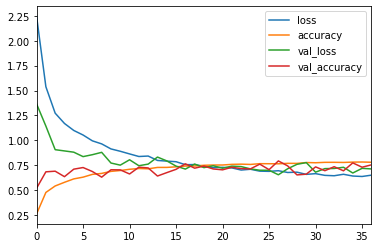

In [14]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

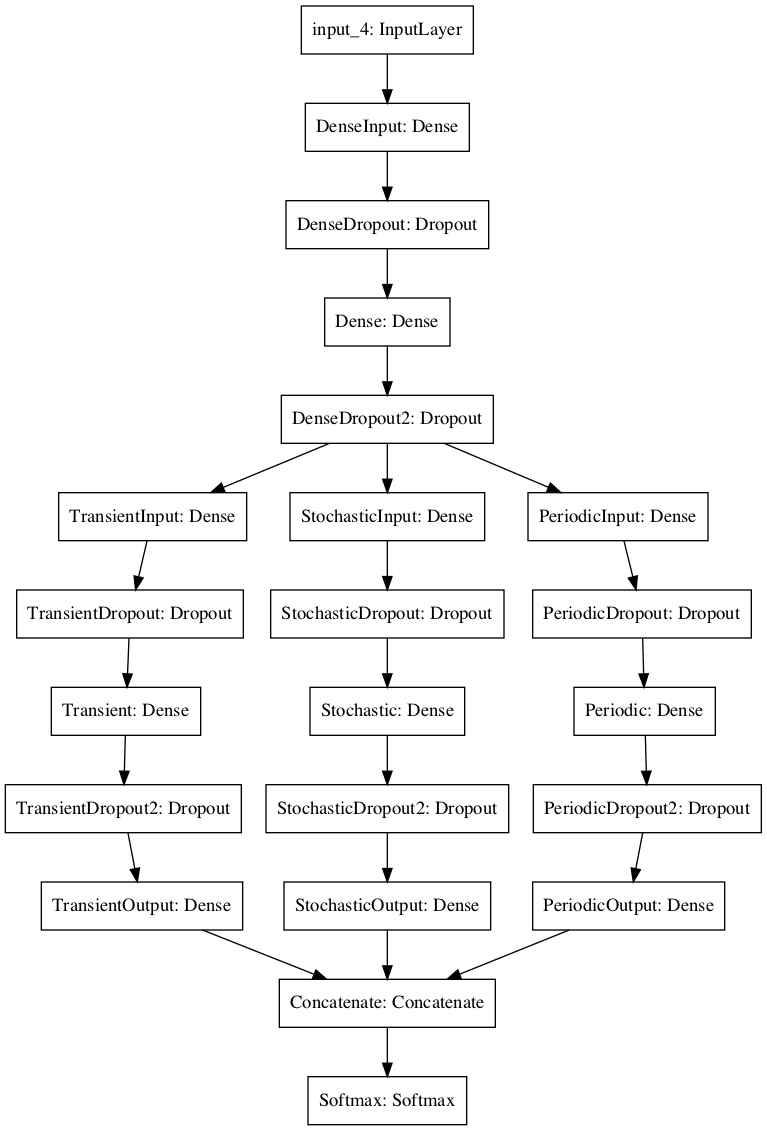

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [16]:
#predictions = model.predict_classes(X_test)
pred_proba = model.predict(X_test)
final_proba = np.amax(pred_proba,axis=1)
predictions = np.argmax(pred_proba,axis=1)
print(predictions)
predictions_names = decode_array(predictions)

print(predictions_names)

[13 14 13 ...  6  8  8]
['RRL', 'Ceph', 'RRL', 'LPV', 'EBSD/D', 'LPV', 'EBSD/D', 'QSO-I', 'RRL', 'LPV', 'CV/Nova', 'RRL', 'LPV', 'CV/Nova', 'LPV', 'EBC', 'EBC', 'Ceph', 'LPV', 'EBC', 'EBSD/D', 'LPV', 'RRL', 'EBSD/D', 'EBSD/D', 'Ceph', 'QSO-I', 'EBSD/D', 'LPV', 'LPV', 'EBC', 'DSCT', 'LPV', 'RRL', 'Ceph', 'CV/Nova', 'LPV', 'RRL', 'QSO-I', 'DSCT', 'LPV', 'EBSD/D', 'QSO-I', 'QSO-I', 'RRL', 'EBSD/D', 'LPV', 'RRL', 'LPV', 'EBSD/D', 'QSO-I', 'RRL', 'Periodic-Other', 'LPV', 'DSCT', 'LPV', 'RRL', 'YSO', 'EBC', 'EBSD/D', 'RRL', 'QSO-I', 'EBSD/D', 'RRL', 'RRL', 'AGN-I', 'LPV', 'EBC', 'Periodic-Other', 'RRL', 'RRL', 'RRL', 'Periodic-Other', 'EBSD/D', 'EBSD/D', 'DSCT', 'QSO-I', 'RRL', 'RRL', 'EBSD/D', 'RRL', 'RRL', 'EBSD/D', 'RRL', 'LPV', 'RRL', 'Periodic-Other', 'RS-CVn', 'LPV', 'QSO-I', 'AGN-I', 'LPV', 'EBC', 'EBSD/D', 'EBC', 'RRL', 'RRL', 'LPV', 'RS-CVn', 'RRL', 'RRL', 'EBC', 'EBSD/D', 'LPV', 'QSO-I', 'SNII', 'Periodic-Other', 'LPV', 'LPV', 'LPV', 'RS-CVn', 'RRL', 'LPV', 'QSO-I', 'EBC', 'QSO-I',

In [17]:


print("Accuracy:", metrics.accuracy_score(y_test_original, predictions))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, predictions))

#Dumping trained model

features_list = list(X_train_original)


Accuracy: 0.7479919228180391
Balanced accuracy: 0.6054451026247452


In [18]:
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[1579  150   50    3    5    0    0    0    1    4    1    3    0    0
     0    1    7]
 [  82  309   21    1    9    3    0    2    0    1    0    0    0    0
     1    0    0]
 [  33   17  117    7    6    0    0    0    0    0    0    0    0    0
     1    0    1]
 [   1    1    5  115    1   10    0    0    0    1    1    3    8    2
     0    3    5]
 [   1    1    3    0  175    0    0    0    0    1    1    0    0    3
    12   19    5]
 [   0    0    0    4    0  119    3    5    1    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    7    1    1    0    0    0    0    0    0
     0    0    0]
 [   0    2    0    2    0   11    0   23    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    3    0    0    0    0    1    0
     0    0    0]
 [  10    3   13   19   10    0    0    2    0 2772  920  248  112  101
     5  399  425]
 [   1    0    0    6    1    0    0    0    0  567  474   55   29   29
     2  110   79]
 [   0    

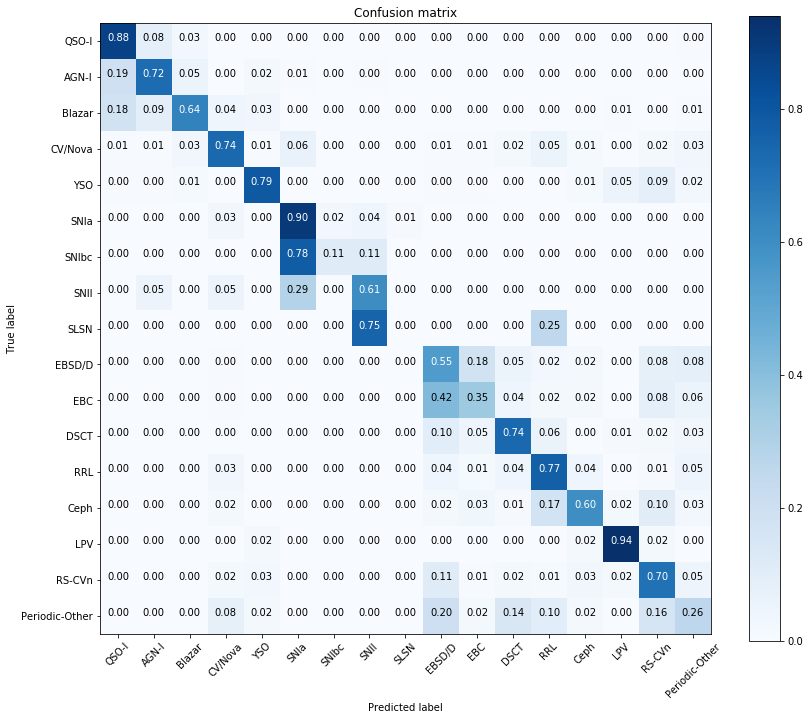

In [19]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(decode_array(y_test_original), decode_array(predictions), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

In [20]:
# Kaggle score

CLASSES_REDUCED_V2 = label_order


class_weights = list(class_weight.compute_class_weight('balanced', encode_array(label_order), y_test_original))


def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = encode_array(CLASSES_REDUCED_V2)#np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba,class_weights))

YSO -3.396225557909197
SNIa -8.173293868567855
SNIbc -127.06108375312458
SNII -41.34484918309439
EBSD/D -0.20155812930202446
QSO-I -0.2637941904829552
AGN-I -16.722719420887195
Blazar -11.836006584557396
CV/Nova -50.13485904822342
EBC -1.0922872108001562
DSCT -11.99892792916983
RRL -0.21681161207025756
Ceph -9.266052493049056
LPV -0.25517077422254175
SLSN -70.5539090087747
RS-CVn -10.194001015125782
Periodic-Other -92.8591818711337
0.7578003842205441


  ## Classifying unlabeled data

In [21]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [22]:
#predicting classes of unlabeled data

x_test_scaled = scaler.transform(df_feat_ul)-0.5
print(x_test_scaled.shape)
test_Y_proba = model.predict(x_test_scaled)
test_Y_final_proba = np.amax(test_Y_proba,axis=1)
test_Y_predictions = np.argmax(test_Y_proba,axis=1)
test_Y_predictions_names = decode_array(test_Y_predictions)

print(len(test_Y_predictions_names))

(653905, 136)
653905


In [23]:
print(np.amax(test_Y_proba,axis=1))

[0.567859   0.5394854  0.5298317  ... 0.77248794 0.82888794 0.5589633 ]


In [24]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y_predictions_names
df_out['predicted_class_proba'] = test_Y_final_proba
#test_data_withclass = df_out

#'''

probs_header = decode_array(np.arange(0,17))#prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(test_Y_proba,columns=probs_header,index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
#'''

(653905, 136)


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,CV/Nova,LPV,YSO,EBSD/D,EBC,DSCT,RRL,Ceph,RS-CVn,Periodic-Other
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,0.003083,0.001223,0.021222,0.097178,0.059192,0.005350,0.009773,0.010869,0.215686,0.567859
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,0.006360,0.021372,0.539485,0.027828,0.017978,0.006360,0.006360,0.017097,0.234090,0.078552
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,0.000007,0.000003,0.000006,0.529832,0.463582,0.001206,0.003571,0.000289,0.001047,0.000434
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,0.000122,0.000024,0.000033,0.582720,0.382576,0.004772,0.010660,0.000914,0.006819,0.011193
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,0.003127,0.000294,0.000944,0.472356,0.358253,0.009166,0.015435,0.006295,0.088305,0.043770


In [25]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(653905, 155)

Text(0.5, 1.0, 'sources classified')

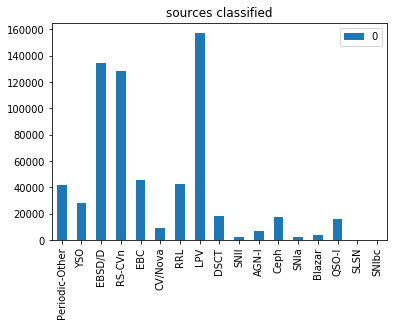

In [26]:
letter_counts = Counter(test_Y_predictions_names)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


0 QSO-I 0.6841403841972351
1 AGN-I 0.6843720078468323
2 Blazar 0.6065671443939209
3 CV/Nova 0.6470973193645477
4 YSO 0.754679411649704
5 SNIa 0.9574604332447052
6 SNIbc 0.8688763678073883
7 SNII 0.7818419337272644
8 SLSN 0.9407251477241516
9 EBSD/D 0.4968077540397644
10 EBC 0.4880816340446472
11 DSCT 0.47294560074806213
12 RRL 0.7182902693748474
13 Ceph 0.32356931269168854
14 LPV 0.9839562773704529
15 RS-CVn 0.6348041594028473
16 Periodic-Other 0.5693244934082031


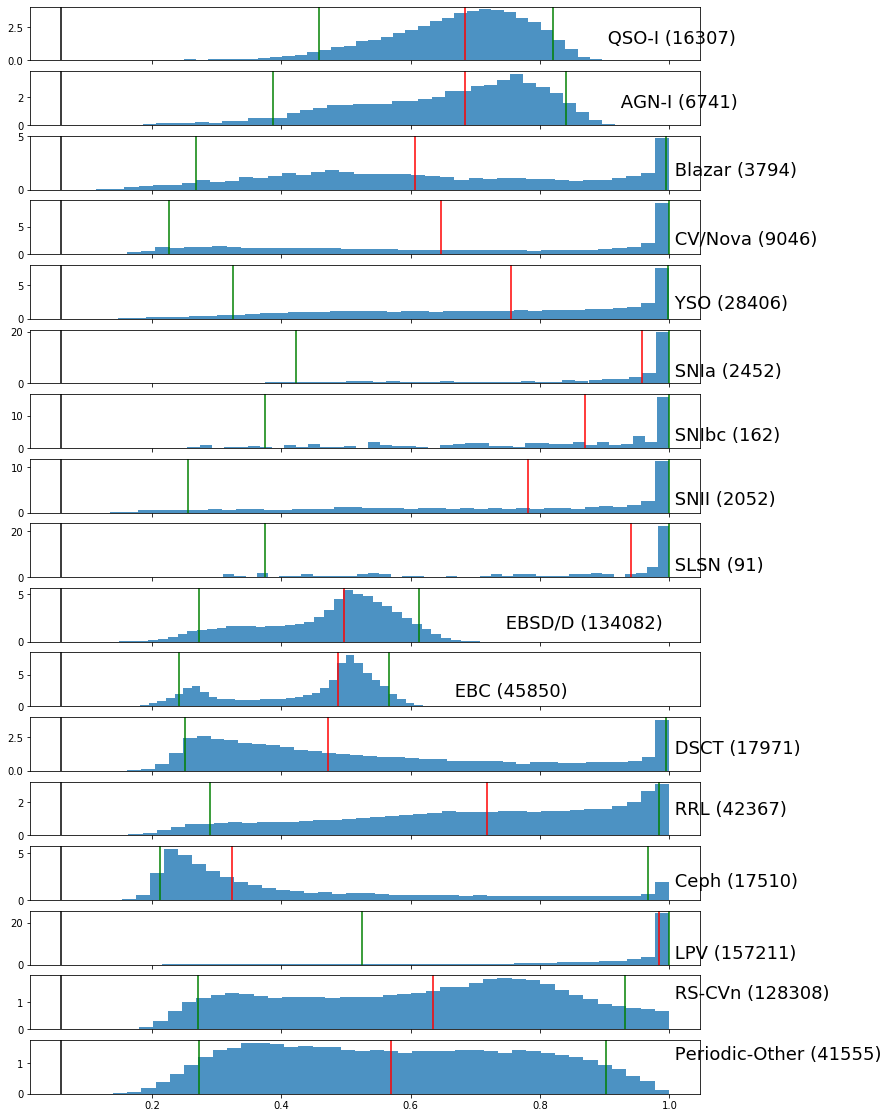

In [27]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO-I 0.11459617685430068
1 AGN-I 0.1568970179563518
2 Blazar 0.3936305181058977
3 CV/Nova -0.025153739921998763
4 YSO 1.6561184274155991
5 SNIa 0.010153095444898952
6 SNIbc 0.42910861968995023
7 SNII 0.1709003448486488
8 SLSN 0.15327644348140268
9 EBSD/D 0.547338835339902
10 EBC 0.5682365305430022
11 DSCT 0.0373906900739982
12 RRL 0.0596858587444018
13 Ceph 0.7970160313865993
14 LPV 2.2658560465057516
15 RS-CVn 0.8990823419966016
16 Periodic-Other 0.4781691601197995


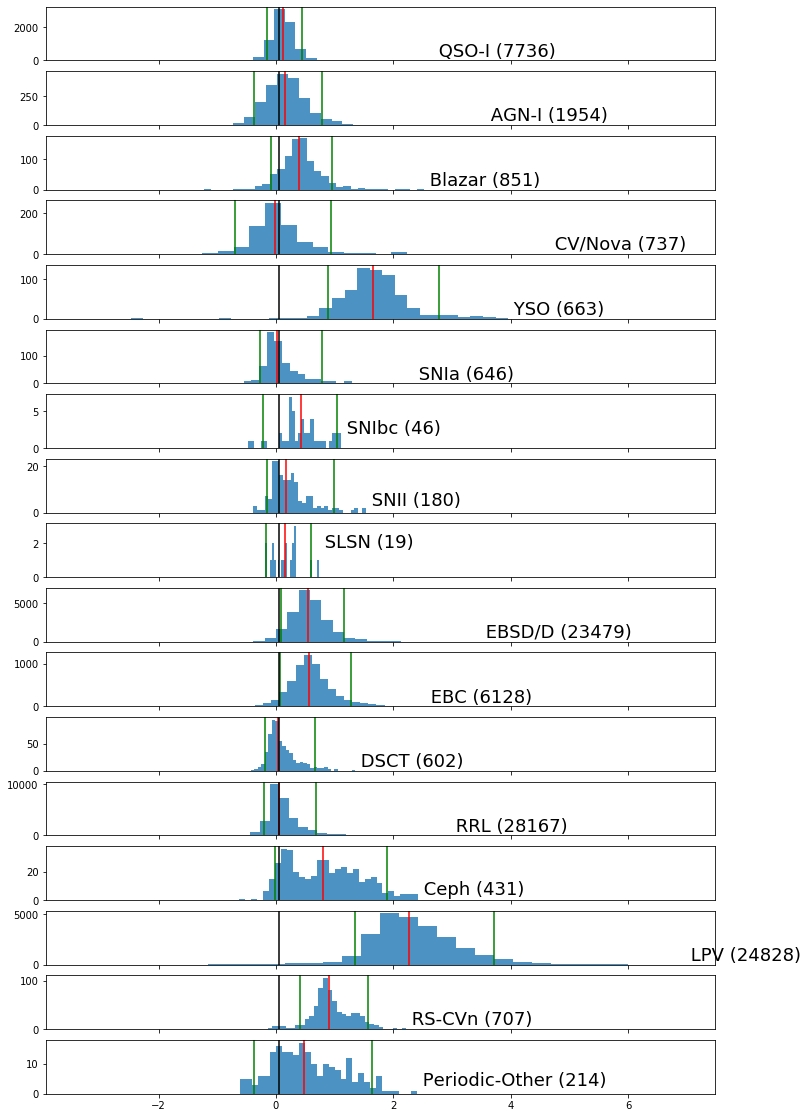

In [28]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

QSO-I 13702
AGN-I 5869
Blazar 3235


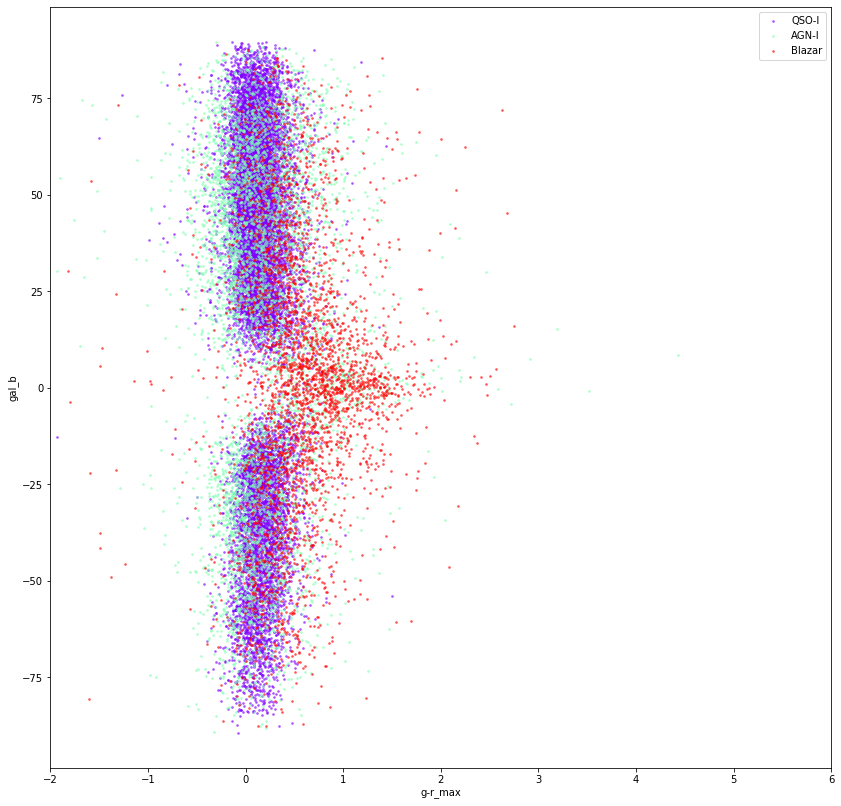

In [29]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

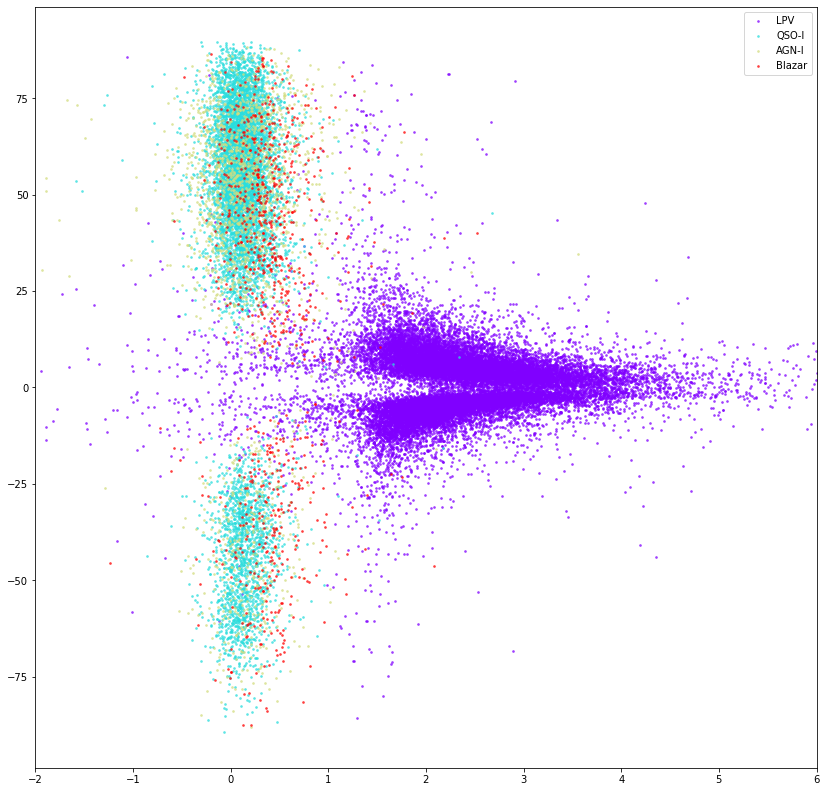

In [30]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')